# Linear Regression 

We trained a linear regression model for the Energy Efficient dataset from the UC Irivine Machine Learning Repository. More about the data in the following EDA.

## Part 1: Loading the dataset.

Fetching the dataset from ucimlrepo with id=242. This is obtained from the API in their website [UCI ML](https://archive.ics.uci.edu/dataset/242/energy+efficiency).

In [1]:
!pip install -q ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
energy_efficiency = fetch_ucirepo(id=242)

Loading the necessary modules for training, visualization, and EDA.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Part 2: Exploratory Data Analysis

We performed exploratory data analysis to gain coarse insights of what can we extract from the dataset. Let's have a quick look of the data.

In [3]:
print(f'Length:     {len(energy_efficiency.data.features)}')
print(f'Dimensions: ({len(energy_efficiency.variables)},{len(energy_efficiency.data.features)})')
print(f'Missing:    {energy_efficiency.variables.missing_values.unique().sum()}')
print(f'Features:   {(energy_efficiency.variables.role == "Feature").sum()}')
print(f'Labels:     {(energy_efficiency.variables.role == "Target").sum()}')

variables = energy_efficiency.variables.description.to_list()
types = energy_efficiency.variables.type.to_list()

Length:     768
Dimensions: (10,768)
Missing:    no
Features:   8
Labels:     2


There are 768 data points without any missing value for any feature or label fields. There are 10 variables with 8 features and 2 labels. Below is the metadata about the variables. Our goal is to **determine the variables that contribute to heating and cooling loads with their corresponding weights**.

In [4]:
energy_efficiency.variables[['name', 'role' ,'type' , 'description']]

,name,role,type,description
0,X1,Feature,Continuous,Relative Compactness
1,X2,Feature,Continuous,Surface Area
2,X3,Feature,Continuous,Wall Area
3,X4,Feature,Continuous,Roof Area
4,X5,Feature,Continuous,Overall Height
5,X6,Feature,Integer,Orientation
6,X7,Feature,Continuous,Glazing Area
7,X8,Feature,Integer,Glazing Area Distribution
8,Y1,Target,Continuous,Heating Load
9,Y2,Target,Continuous,Cooling Load


Since the `energy_efficiency` dataset includes metadata, we obtained the dataset.

In [5]:
df = pd.concat([energy_efficiency.data.features, energy_efficiency.data.targets], axis=1)

Plot multiple scatterplots to see any trends with the features x labels.

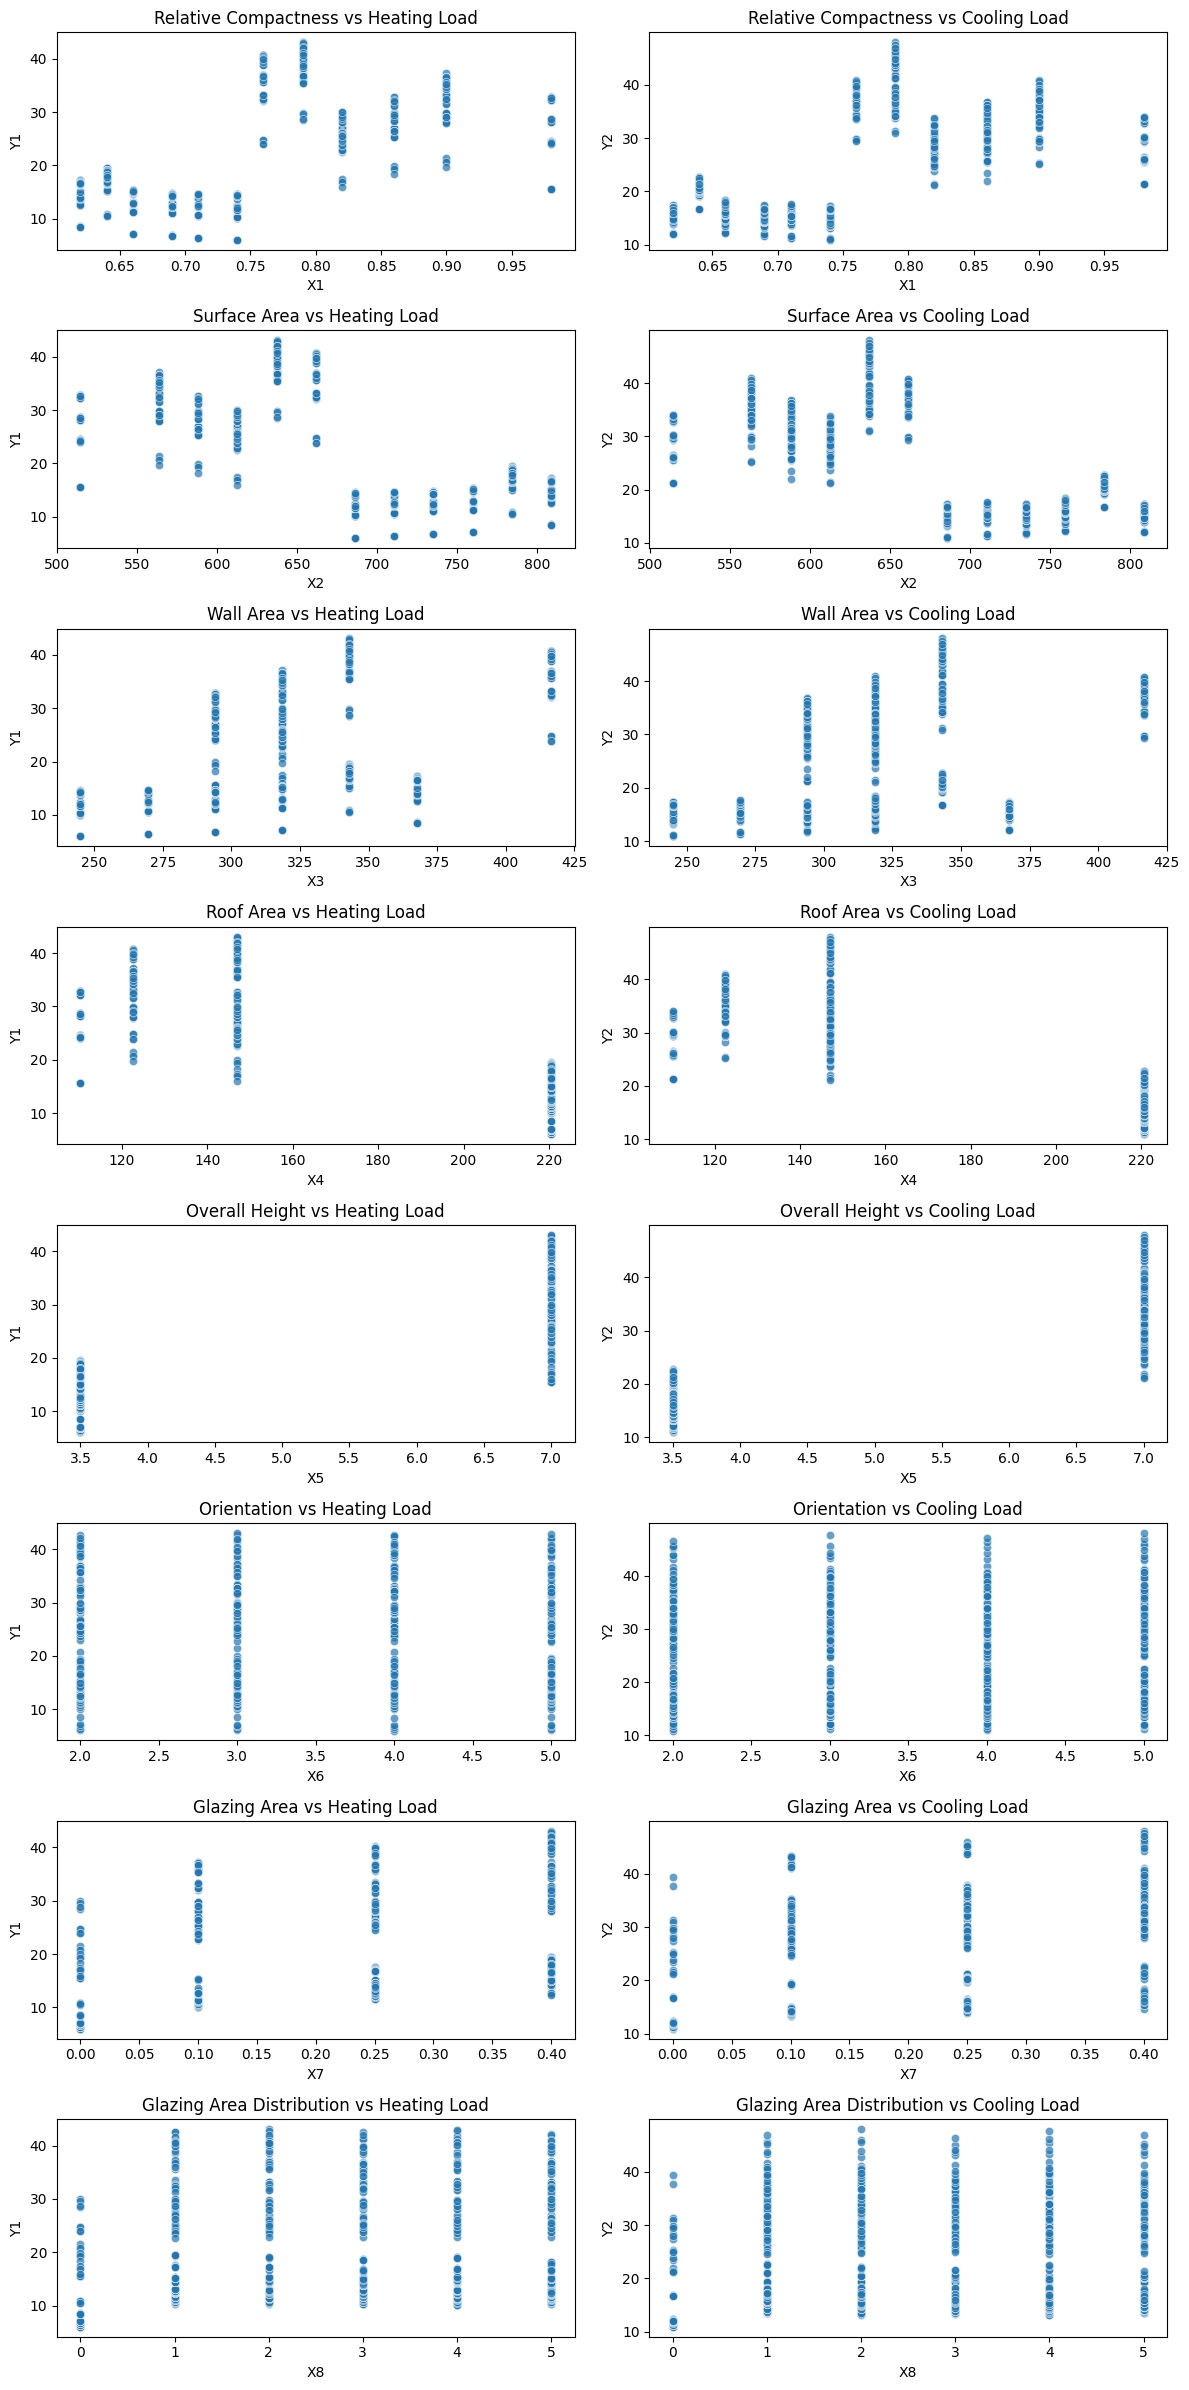

In [6]:
fig, axes = plt.subplots(8, 2, figsize=(12, 24))

for i in range(8):
    feature = 'X' + str((i+1))
    feature_name = energy_efficiency.variables[energy_efficiency.variables.name == feature].description[i]

    sns.scatterplot(data=df, x=feature, y='Y1', ax=axes[i, 0], alpha=0.7)
    axes[i, 0].set_title(f'{feature_name} vs Heating Load')

    sns.scatterplot(data=df, x=feature, y='Y2', ax=axes[i, 1], alpha=0.7)
    axes[i, 1].set_title(f'{feature_name} vs Cooling Load')

plt.tight_layout()
plt.show()

We can see that even though the variables are continuous, they are bucketized in discrete values. This means that a scatterplot is not really the proper viz to extract trends from the dataset but a **line plot**.

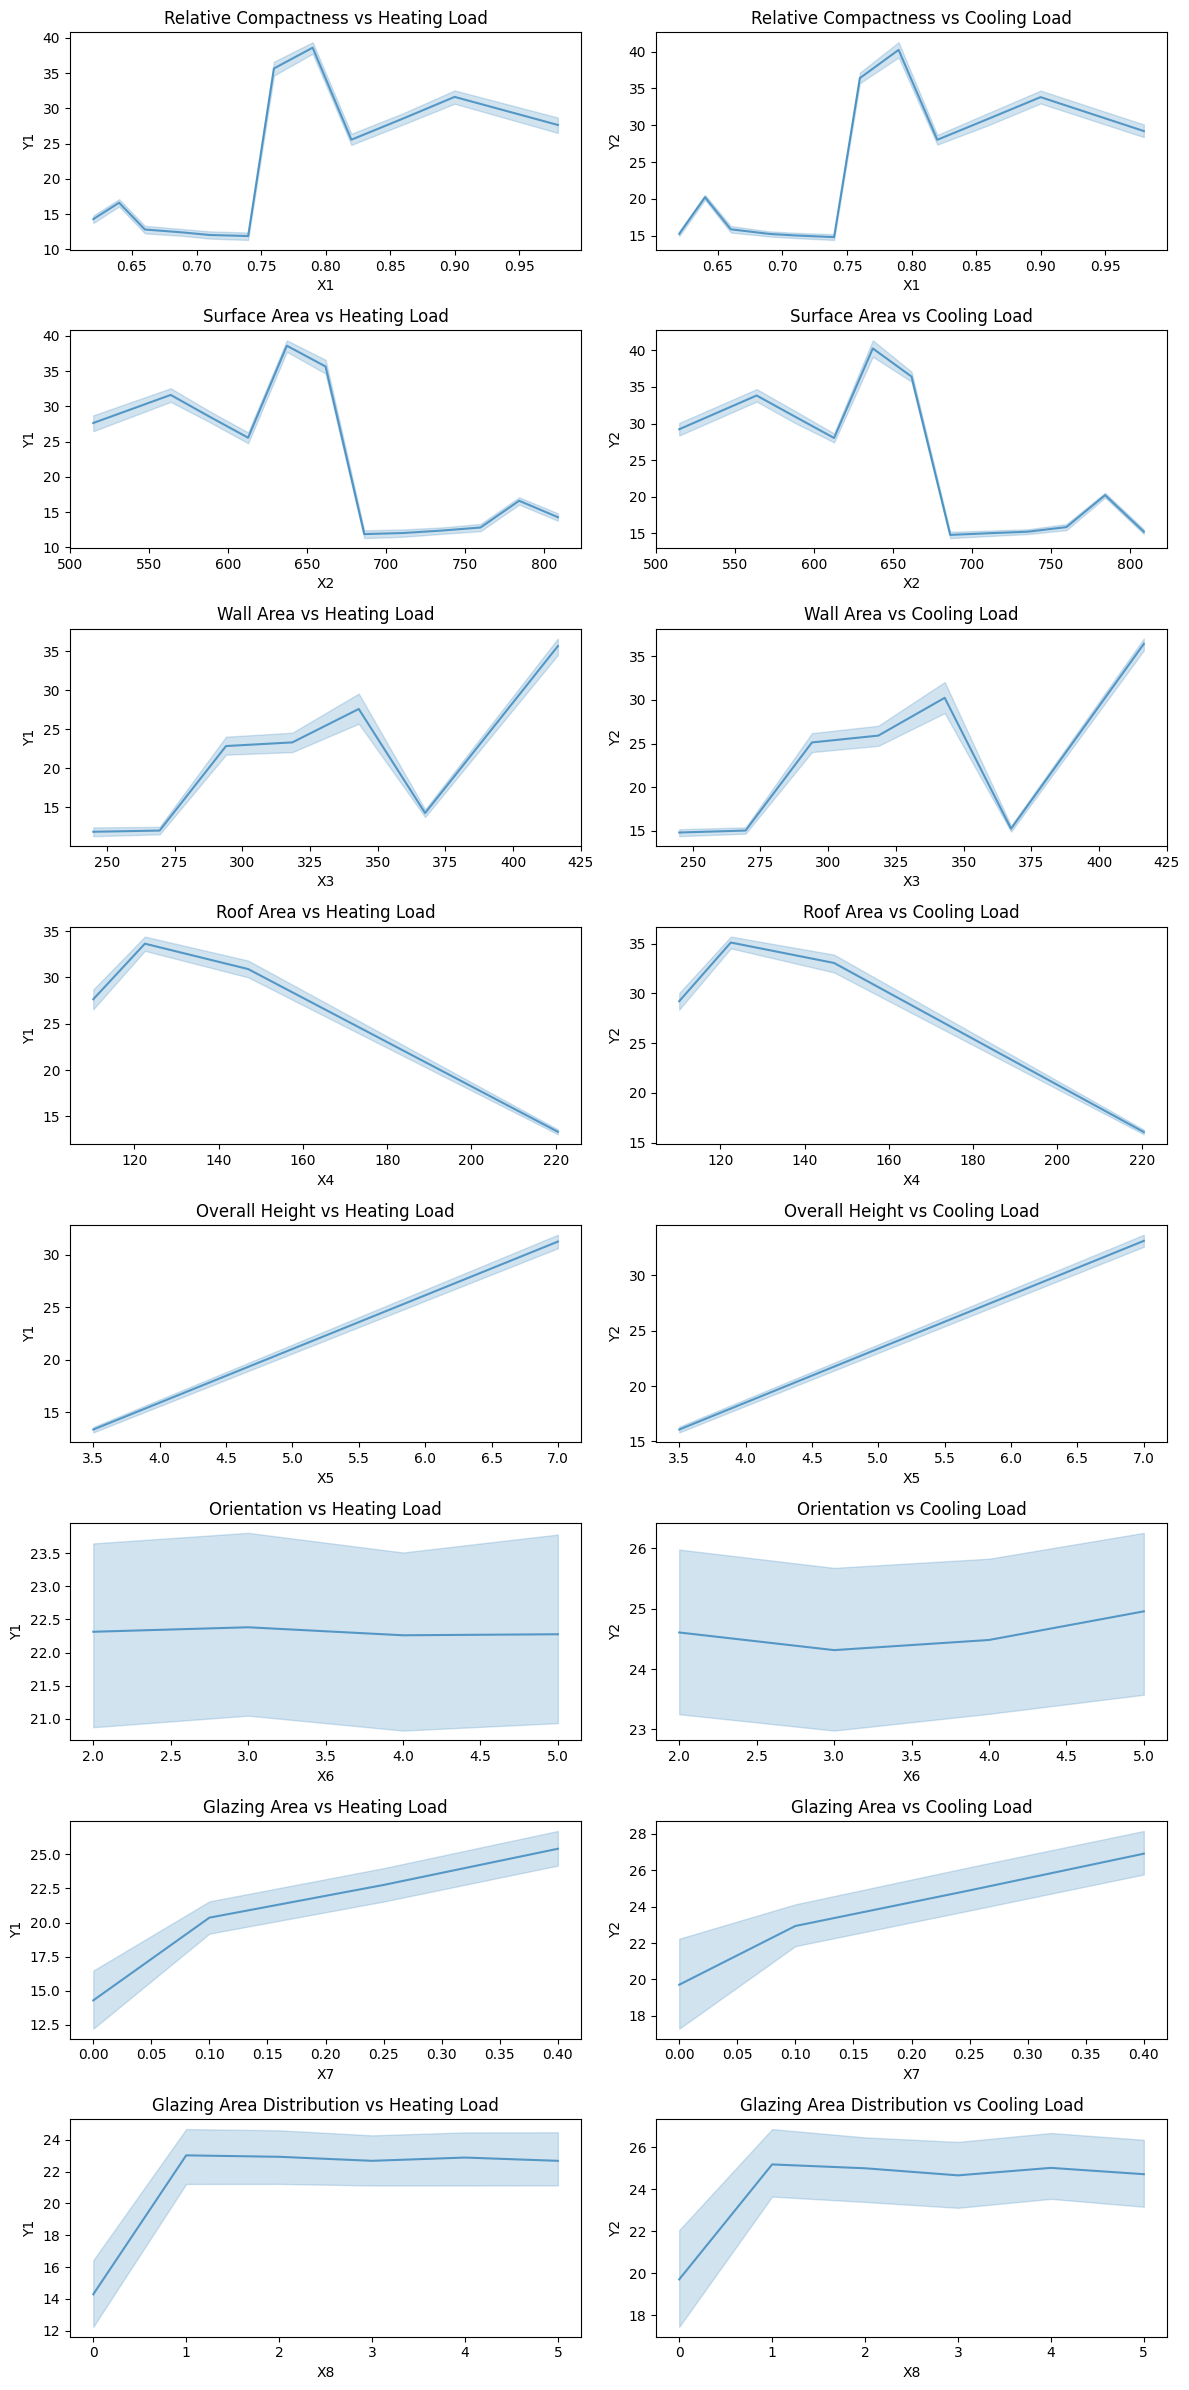

In [7]:
fig, axes = plt.subplots(8, 2, figsize=(12, 24))

for i in range(8):
    feature = 'X' + str((i+1))
    feature_name = energy_efficiency.variables[energy_efficiency.variables.name == feature].description[i]

    sns.lineplot(data=df, x=feature, y='Y1', ax=axes[i, 0], alpha=0.7)
    axes[i, 0].set_title(f'{feature_name} vs Heating Load')

    sns.lineplot(data=df, x=feature, y='Y2', ax=axes[i, 1], alpha=0.7)
    axes[i, 1].set_title(f'{feature_name} vs Cooling Load')

plt.tight_layout()
plt.show()

## Part 3: Model Training

In model training, we focused on the predicting the heating load given the features above. We used multiple linear regression regularized by ridge regression. The objective of this training is to identify the best hyperparameter alpha value for the ridge regression.

### Step 1. Splitting the data

We splitted the data into 60% training, 20% testing, and 20% validation.

In [8]:
from sklearn.model_selection import train_test_split

x = energy_efficiency.data.features
y = energy_efficiency.data.targets.Y1

# Get 60% training and 40% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=69)

# Further split 40% testing to 20% validation and 20% siloed testing
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=420)

print(f"Traning size: {len(x_train)}")
print(f"Validation size: {len(x_val)}")
print(f"Test: {len(y_test)}")

Traning size: 460
Validation size: 154
Test: 154


### Step 2. Ridge Regularization

We chose 10 different ridge regularization values in which we obtained each accuracy in the validation set. We created a function that takes in a set of features and performs ridge regularization on it. Additionally, we created another function for evaluating the model.

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def ridge_lr(alpha,
             training_features=x_train,
             training_labels=y_train,
             test_features=x_val,
            ):
    """ Perform linear regression with ridge regularization. """
    
    model_ridge = Ridge(alpha=alpha)
    model_ridge.fit(training_features, training_labels)
    predictions = model_ridge.predict(test_features)

    
    return predictions, model_ridge

In [10]:
predictions, model = ridge_lr(1e-2, test_features=x_test)


In [11]:
def eval_lr(truth, predictions: list, names=[""]):
    """ Evaluate linear regression models with R2, MSE, RMSE, and NMSE. """

    r2s, mses, rmses, nmses = [], [], [], []
    for prediction in predictions:
        r2 = r2_score(truth, prediction)
        mse = mean_squared_error(truth, prediction)
        rmse = np.sqrt(mse)
        nmse = mse / np.var(truth) 
        r2s.append(r2)
        mses.append(mse)
        rmses.append(rmse)

    results = pd.DataFrame({
        "r2": r2s,
        "mse": mses,
        "rmse": rmses,
    }, index=names)

    return results

We initially trained the model with ridge regression for the following alphas. Is this a coincidence? It looks like the sigmoid/logistic function.

                r2        mse      rmse
0.0001    0.926392   7.484246  2.735735
0.001     0.926373   7.486114  2.736076
0.01      0.926113   7.512634  2.740919
0.1       0.923998   7.727636  2.779863
1.0       0.922025   7.928203  2.815707
10.0      0.905132   9.645832  3.105774
100.0     0.860443  14.189727  3.766925
1000.0    0.828971  17.389706  4.170097
10000.0   0.817970  18.508235  4.302120
100000.0  0.812748  19.039209  4.363394


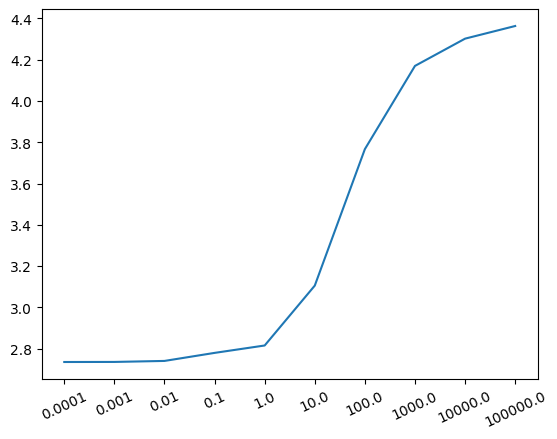

In [12]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]

predictions = []
for alpha in alphas:
    prediction, _ = ridge_lr(alpha)
    predictions.append(prediction)

results = eval_lr(y_val, predictions, names=[f"{alpha}" for alpha in alphas])
print(results)
plt.xticks(rotation=25)
plt.plot(results.rmse);

### Step 3. Final Evaluation

We evaluated the best value for the ridge regularization hyperparameter. We found out that the best model has an alpha of 0.01 with an R2 score of 0.918735.

In [13]:
predictions, model = ridge_lr(1e-2, test_features=x_test)

results = eval_lr(y_test, [predictions])
print(results)

        r2       mse      rmse
  0.920539  8.166739  2.857751


We can see that the test set produces comparable results with the validation set. We can assume that this is the best ridge regression model for our dataset.

### Step 4. Post Training Analysis

We identified the best model's coefficients and intercepts including the training, validation, and test accuracies.

In [14]:
coefficients = np.argsort(np.abs(model.coef_))[::-1]
features = [f"X{i+1}: {round(model.coef_[i], 2)}" for i in coefficients]

print("Model parameters:")
for feature in features:
    print(feature)
print(f"Intercept: {round(model.intercept_, 2)}")

Model parameters:
X1: -47.5
X7: 20.51
X5: 4.68
X8: 0.34
X6: -0.1
X2: -0.04
X4: -0.04
X3: 0.04
Intercept: 50.36


In [15]:
test_features = [x_val, x_test]

predictions = []
for test_feature in test_features:
    prediction, _ = ridge_lr(alpha=1e-2,
                             test_features=test_feature)
    predictions.append(prediction)

test_labels = [y_val, y_test]
names = ['validation','test      ']
for ix, test_label in enumerate(test_labels):
    print(eval_lr(test_label, [predictions[ix]], [names[ix]]))

                  r2       mse      rmse
validation  0.926113  7.512634  2.740919
                  r2       mse      rmse
test        0.920539  8.166739  2.857751


### Step 5. Best Features
From there, we obtained the top 5 best features of the linear regression model. We found out that the top 5 most important features are X1, X7, X5, X8, and X6. Which are

In [16]:
top_5 = np.argsort(np.abs(model.coef_))[::-1][:5]
top_5_names = [f"X{i+1}" for i in top_5]
features = [f"{name}: {round(model.coef_[coef], 2)}" for name, coef in zip(top_5_names,top_5)]

print("Top 5 parameters:")
for feature in features:
    print(feature)

Top 5 parameters:
X1: -47.5
X7: 20.51
X5: 4.68
X8: 0.34
X6: -0.1


### Step 6. Feature Ablation
Lastly, we trained the original dataset using the top 5 best features using the function we created earlier.


In [19]:
nx = energy_efficiency.data.features[top_5_names]
ny = energy_efficiency.data.targets.Y1

# Get 60% training and 40% testing
nx_train, nx_test, ny_train, ny_test = train_test_split(nx, ny, test_size=0.4, random_state=69)

# Further split 40% testing to 20% validation and 20% siloed testing
nx_val, nx_test, ny_val, ny_test = train_test_split(nx_test, ny_test, test_size=0.5, random_state=420)

test_features = [nx_val, nx_test]


                r2         mse       rmse
0.0001    0.919049    8.230844   2.868945
0.001     0.919045    8.231271   2.869019
0.01      0.919002    8.235658   2.869784
0.1       0.918470    8.289755   2.879193
1.0       0.909559    9.195736   3.032447
10.0      0.861265   14.106119   3.755811
100.0     0.810652   19.252349   4.387750
1000.0    0.656651   34.910589   5.908518
10000.0   0.168574   84.536711   9.194385
100000.0  0.003924  101.277857  10.063690


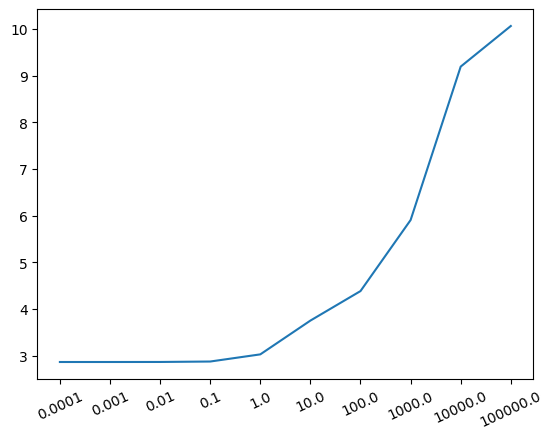

In [20]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]

predictions = []
for alpha in alphas:
    prediction, _ = ridge_lr(alpha, training_features=nx_train, training_labels=ny_train, test_features=nx_val)
    predictions.append(prediction)

results = eval_lr(ny_val,  predictions, names=[f"{alpha}" for alpha in alphas])
print(results)
plt.xticks(rotation=25)
plt.plot(results.rmse);

In [21]:
predictions = []
for test_feature in test_features:
    prediction, _ = ridge_lr(alpha=1e-4,
                             training_features=nx_train,
                             training_labels=ny_train,
                             test_features=test_feature)
    predictions.append(prediction)

test_labels = [ny_val, ny_test]
names = ['validation','test      ']
for ix, test_label in enumerate(test_labels):
    print(eval_lr(test_label, [predictions[ix]], [names[ix]]))

                  r2       mse      rmse
validation  0.919049  8.230844  2.868945
                  r2       mse     rmse
test        0.907583  9.498233  3.08192


## Questions

#### Guide Question 1:
**What is the impact of removing certain features on the model’s performance?**

We can observe a less performant model. This is expected as using the most important features often lead to having a less complex model. This also explains why we need less regularization relative to training with all the features. By removing some of the features, we lost some information that may not be totally important, but still contributes to the overall prediction. Why do they do this? It is because in large scale machine learning applications, the features can have very high dimensions, especially in deep learning. By removing some of the features, we can reduce the dimensionality of our input features which will reduce the training and inference times.

#### Guide Question 2:
**Why is it necessary to split the data into training, validation, and testing sets? What could happen if this step is skipped?**

Think of it as taking an examination, you are given examples of how to solve a certain problem. You practiced some problems that are parallel to the examples given to you which validates the knowledge you have in the subject matter. The test comes out and you performed pretty well. On the other hand, you have a friend that obtained an exam leakage from the other blocks, that friend answered all the exam questions perfectly. The exam day arrived and apparently the professor changed the exam questions for your block and that friend failed.

The same concept of generalizability and familiarization applies to machine learning. The training dataset allows you to extract as much patterns as possible from the dataset. From there, hyperparameter tuning or further training is required to determine the proper hyperparameters to use in training. You can't do this in the test itself because that would beat the purpose of generalizing to any unseen data. Doing it that way would introduce bias to the model, because you are purposely increasing the accuracy of your model based on the test. After validation, you have to train it in a siloed, meaning isolated or unseen, dataset called the testing set. The model performance is benchmarked from the testing set.

#### Guide Question 3:
**How can the generalization ability of the model be assessed using the test data? What steps would you take to ensure the model generalizes well to unseen data?**

Generalizability is one of the fundamental characteristics of a machine learning model. Ultimately, after exploratory data analysis, hyperparameter tuning, and model monitoring, the test data determines the overall performance of a machine learning model. From here, you can determine if the model is overfitted or underfitted to the training and validation sets. Before deploying the model in the real world, you need to know this to troubleshoot any problems that probably arose during training and perform the necessary steps to solve it. Moreover, a testing set may encompass the initial deployment data you received which may show you some usual problems such as training-serving skew and data mismatch.

In order to reduce overfitting and underfitting, you must choose the proper model that introduces just enough model complexity to arrive with a good generalizability. A famous quote from Occam's Razor, "the simplest solution is always the best" is a mantra in choosing the proper model. Model training is an iterative process, you have to choose different models or tune the hyperparameters until you arrive with a performant model. You must adhere to the boring parts to arrive with a good model and achieve optimal generalizability and validate your model with either cross validation techniques or using a validation set. You can also perform encoding techniques, normalization, bucketizing, etc. which essentially increases inclusivity, explainability, and performance converging to optimal generalizability. The test data must be completely isolated from the training and validation sets because any hint given to the model of how the test data is structured or represented introduces bias.

Lastly, regularization techniques allow you to reduce the model complexity. There are several regularization techniques such as L2 or ridge regression that essentially clips the model to only be localized in an area defined by the Euclidean norm. A lighter version of this called L1 or lasso regression clips the model in a diamond-shaped (as viewed in the rectangular plane) area. For deep neural networks. Early stopping which is common in both classical machine learning and deep learning allows you to stop training once the test accuracy reaches its minima while the model is being trained. In deep learning, we have dropout which essentially randomly kills neurons forcing the model to learn several patterns and not familiarize itself too deeply with few patterns. These are few regularization techniques that increases generalizability by shaving off complexity from a model.

## Conclusion

In this laboratory experiment, we learned what is linear regression and the application of ridge regression in regularization. We performed hyperparameter tuning using the validation dataset and learned about the concepts of underfitting and overfitting in the context of machine learning. We learned about the effects of removing some features in training models.